In [189]:
import pandas as pd
from scipy.io import arff
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import TSNE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids,\
                                    EditedNearestNeighbours, InstanceHardnessThreshold
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from pyod.models.xgbod import XGBOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from scipy.stats import mannwhitneyu, shapiro, ttest_1samp
from causalimpact import CausalImpact

import tensorflow as tf
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('darkgrid')

In [22]:
def read_data():
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for i in os.listdir('Brazilian Dataset'):
        if i.endswith('.arff'):
            data = arff.loadarff(f'Brazilian Dataset/{i}' )
            df_ = pd.DataFrame(data[0])
            if i.split('_')[1] == 'desenv':
                df_train = df_train.append(df_)
            else:
                df_test = df_test.append(df_)

    return df_train, df_test

df_train, df_test = read_data()

## EDA

In [23]:
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [ ]:
df_train['flag_fraude_cat'] = LabelEncoder().fit_transform(df_train['flag_fraude_cat'])

In [109]:
df_test['flag_fraude_cat'] = LabelEncoder().fit_transform(df_test['flag_fraude_cat'])

In [ ]:
df_train['valor_diff'] = abs(df_train['valor_trans_cat'] - df_train['valor_trans_ant_cat'])

In [116]:
df_test['valor_diff'] = abs(df_test['valor_trans_cat'] - df_test['valor_trans_ant_cat'])

In [25]:
len(df_train), len(df_test)

(28377, 27666)

In [ ]:
# for column in df_train.columns[:-1]:
#     df_train[column] = df

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28377 entries, 0 to 7329
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mcc_cat              28377 non-null  float64
 1   mcc_ant_cat          28377 non-null  float64
 2   cep_cat              28377 non-null  float64
 3   cep_ant_cat          28377 non-null  float64
 4   valor_trans_cat      28377 non-null  float64
 5   valor_trans_ant_cat  28377 non-null  float64
 6   pos_entry            28377 non-null  float64
 7   lim_cred_cat         28377 non-null  float64
 8   bandeira_cat         28377 non-null  float64
 9   variante_cat         28377 non-null  float64
 10  score_cat            28377 non-null  float64
 11  tp_pessoa_cat        28377 non-null  float64
 12  trans_nacional_cat   28377 non-null  float64
 13  qtde_parc_cat        28377 non-null  float64
 14  velocidade_cat       28377 non-null  float64
 15  dif_score_cat        28377 non-null  

In [30]:
df_train.describe()

,mcc_cat,mcc_ant_cat,cep_cat,cep_ant_cat,valor_trans_cat,valor_trans_ant_cat,pos_entry,lim_cred_cat,bandeira_cat,variante_cat,score_cat,tp_pessoa_cat,trans_nacional_cat,qtde_parc_cat,velocidade_cat,dif_score_cat,trans_limit_cat
count,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000,28377.000000
mean,10.885224,7.414913,3.938401,2.558939,5.039151,3.647003,3.257039,6.012827,1.915389,1.993340,0.690383,0.981041,0.005215,1.227825,3.533002,2.919336,0.070374
std,6.278881,7.339551,2.431819,2.665178,2.450320,2.728641,2.784700,2.339727,1.547138,0.813652,1.771458,0.136383,0.072031,0.484468,1.737914,1.039642,0.399131
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,6.000000,0.000000,2.000000,0.000000,3.000000,1.000000,2.000000,4.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,9.000000,6.000000,4.000000,2.000000,5.000000,3.000000,2.000000,6.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,3.000000,3.000000,0.000000
75%,15.000000,13.000000,6.000000,4.000000,7.000000,6.000000,2.000000,8.000000,2.000000,3.000000,0.000000,1.000000,0.000000,1.000000,5.000000,3.000000,0.000000
max,32.000000,32.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,5.000000,5.000000,9.000000,1.000000,1.000000,3.000000,7.000000,5.000000,9.000000


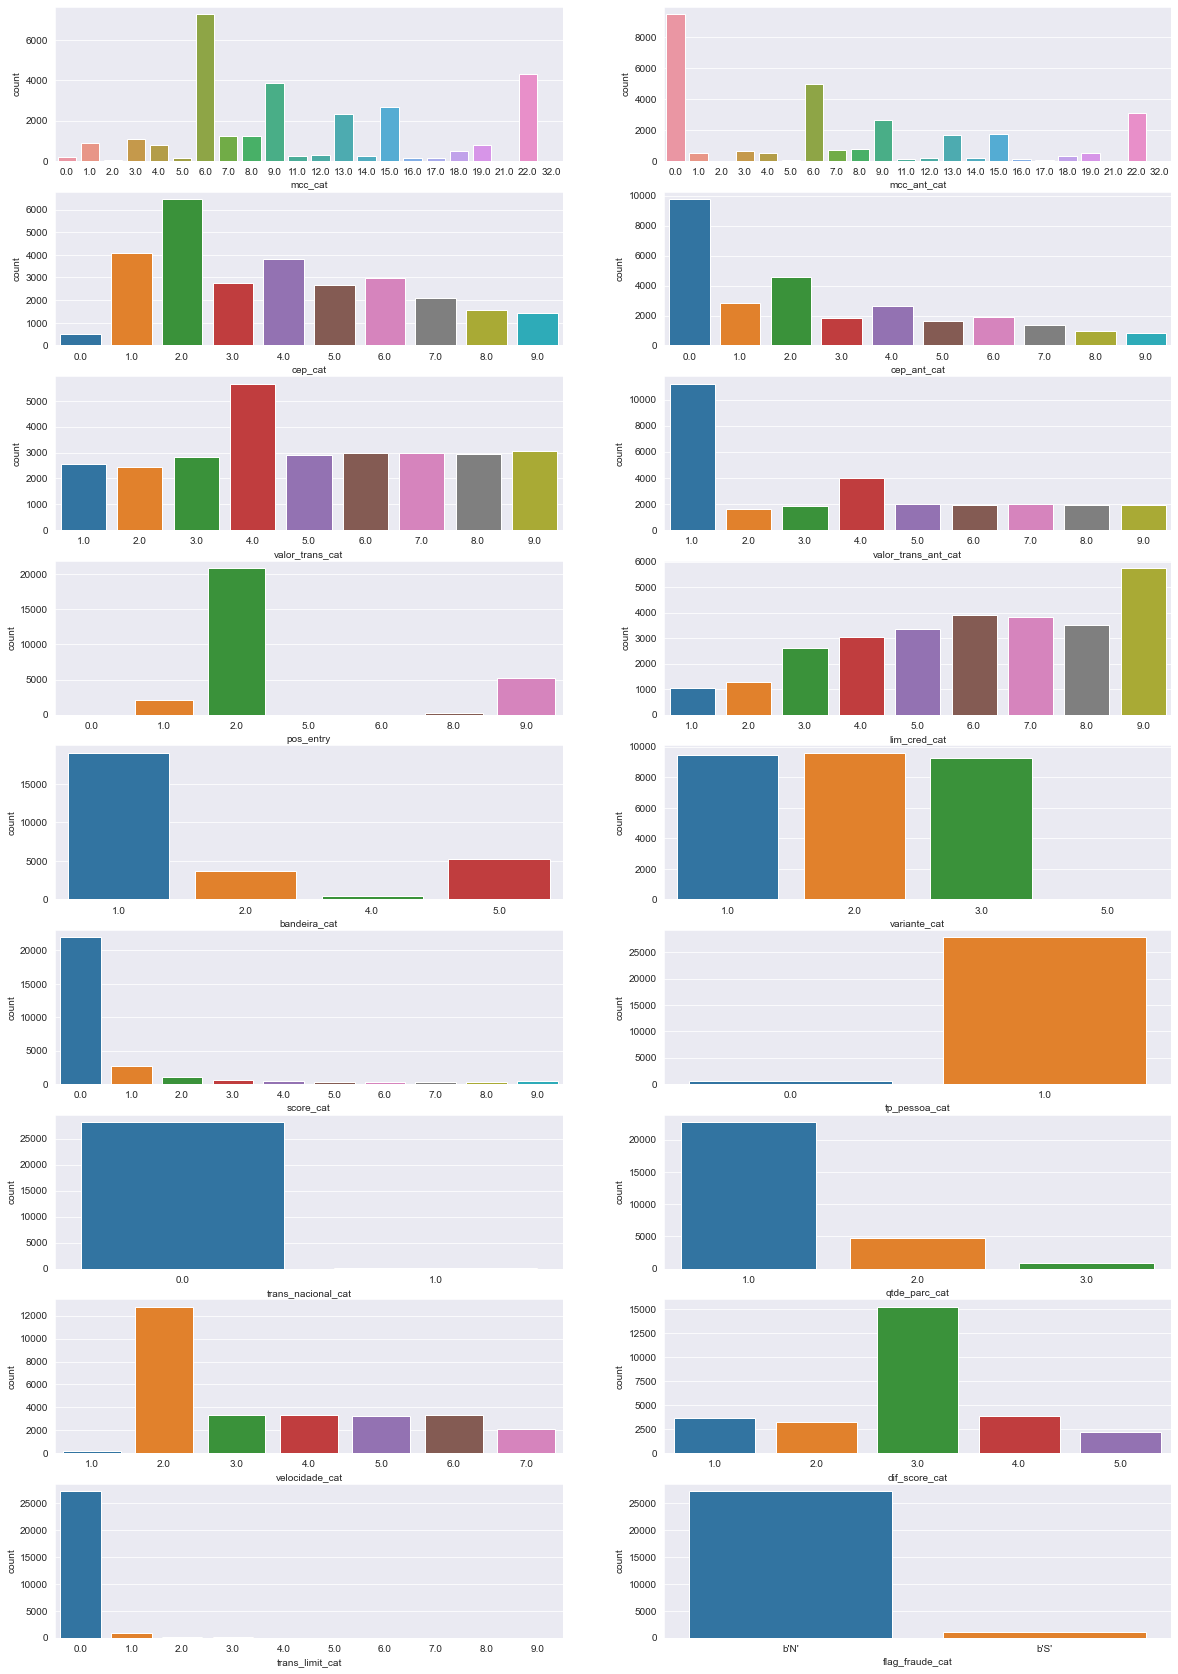

In [34]:
plt.figure(figsize=(20,30))
for i, column in enumerate(df_train.columns):
    plt.subplot(9,2, i+1)
    sns.countplot(df_train[column])

<AxesSubplot:>

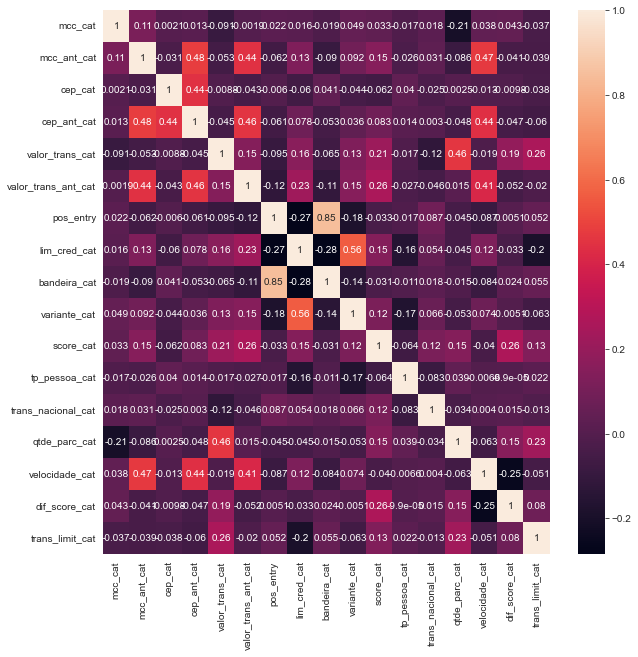

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train.corr(), annot=True)

<AxesSubplot:xlabel='valor_diff', ylabel='count'>

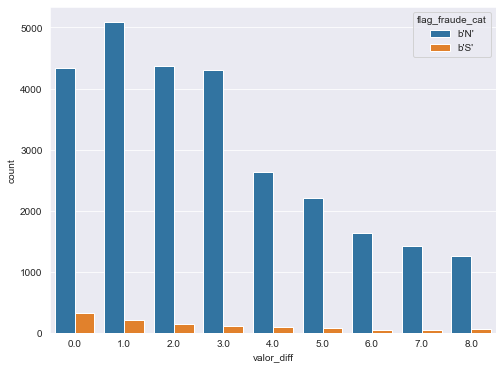

In [45]:
plt.figure(figsize=(8,6))
sns.countplot(df_train['valor_diff'], hue=df_train['flag_fraude_cat'])

<AxesSubplot:xlabel='score_cat', ylabel='count'>

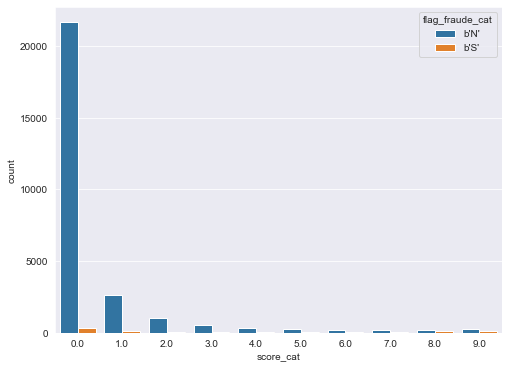

In [46]:
plt.figure(figsize=(8,6))
sns.countplot(df_train['score_cat'], hue=df_train['flag_fraude_cat'])

<AxesSubplot:xlabel='velocidade_cat', ylabel='count'>

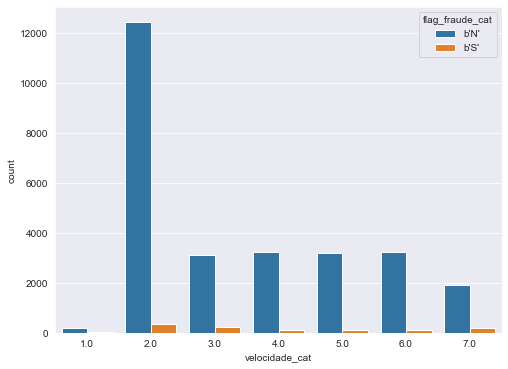

In [47]:
plt.figure(figsize=(8,6))
sns.countplot(df_train['velocidade_cat'], hue=df_train['flag_fraude_cat'])

In [52]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_train.drop(['flag_fraude_cat'], axis=1))

In [53]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(df_train.drop(['flag_fraude_cat'], axis=1))

<AxesSubplot:>

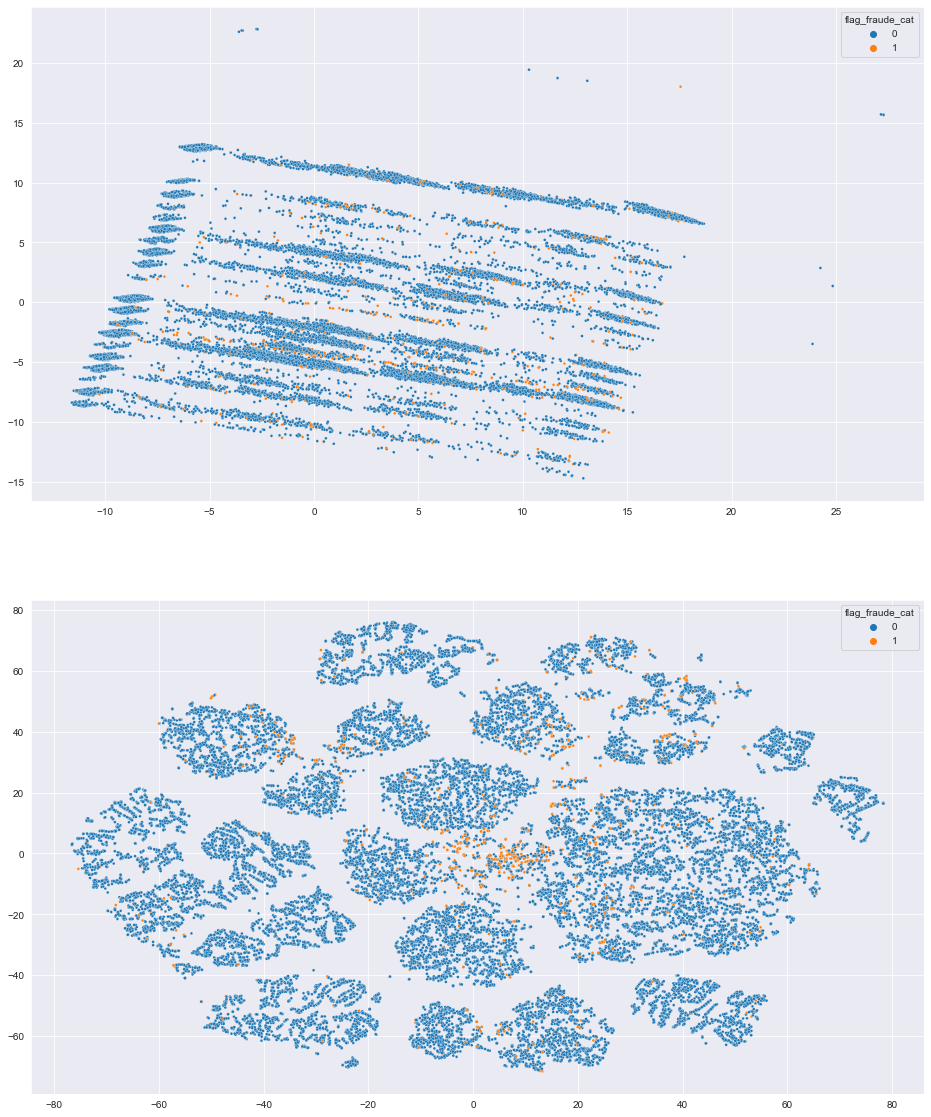

In [72]:
plt.figure(figsize=(16,20))
plt.subplot(2,1,1)
sns.scatterplot(pca_data[:,0], pca_data[:,1], hue=df_train['flag_fraude_cat'], s=8)

plt.subplot(2,1,2)
sns.scatterplot(tsne_data[:,0], tsne_data[:,1], hue=df_train['flag_fraude_cat'], s=8)  

## Balancing Data

In [76]:
X = df_train.drop('flag_fraude_cat', axis = 1)
y = df_train['flag_fraude_cat']

In [117]:
X_test = df_test.drop('flag_fraude_cat', axis = 1)
y_test = df_test['flag_fraude_cat']

In [89]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

pca = PCA(n_components=2)
pca_rus = pca.fit_transform(X_rus)

tsne = TSNE(n_components=2)
tsne_rus = tsne.fit_transform(X_rus)

In [90]:
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X, y)

pca = PCA(n_components=2)
pca_cc = pca.fit_transform(X_cc)

tsne = TSNE(n_components=2)
tsne_cc = tsne.fit_transform(X_cc)

In [91]:
enn = EditedNearestNeighbours(kind_sel="all")
X_enn, y_enn = enn.fit_resample(X, y)

pca = PCA(n_components=2)
pca_enn = pca.fit_transform(X_enn)

tsne = TSNE(n_components=2)
tsne_enn = tsne.fit_transform(X_enn)

In [118]:
enn = EditedNearestNeighbours(kind_sel="all")
X_enn_test, y_enn_test = enn.fit_resample(X_test, y_test)

In [92]:
iht = InstanceHardnessThreshold(random_state=0,
                                estimator=LogisticRegression(
                                    solver='lbfgs', multi_class='auto'))
X_iht, y_iht = iht.fit_resample(X, y)

pca = PCA(n_components=2)
pca_iht = pca.fit_transform(X_iht)

tsne = TSNE(n_components=2)
tsne_iht = tsne.fit_transform(X_iht)

In [119]:
iht = InstanceHardnessThreshold(random_state=0,
                                estimator=LogisticRegression(
                                    solver='lbfgs', multi_class='auto'))
X_iht_test, y_iht_test = iht.fit_resample(X_test, y_test)

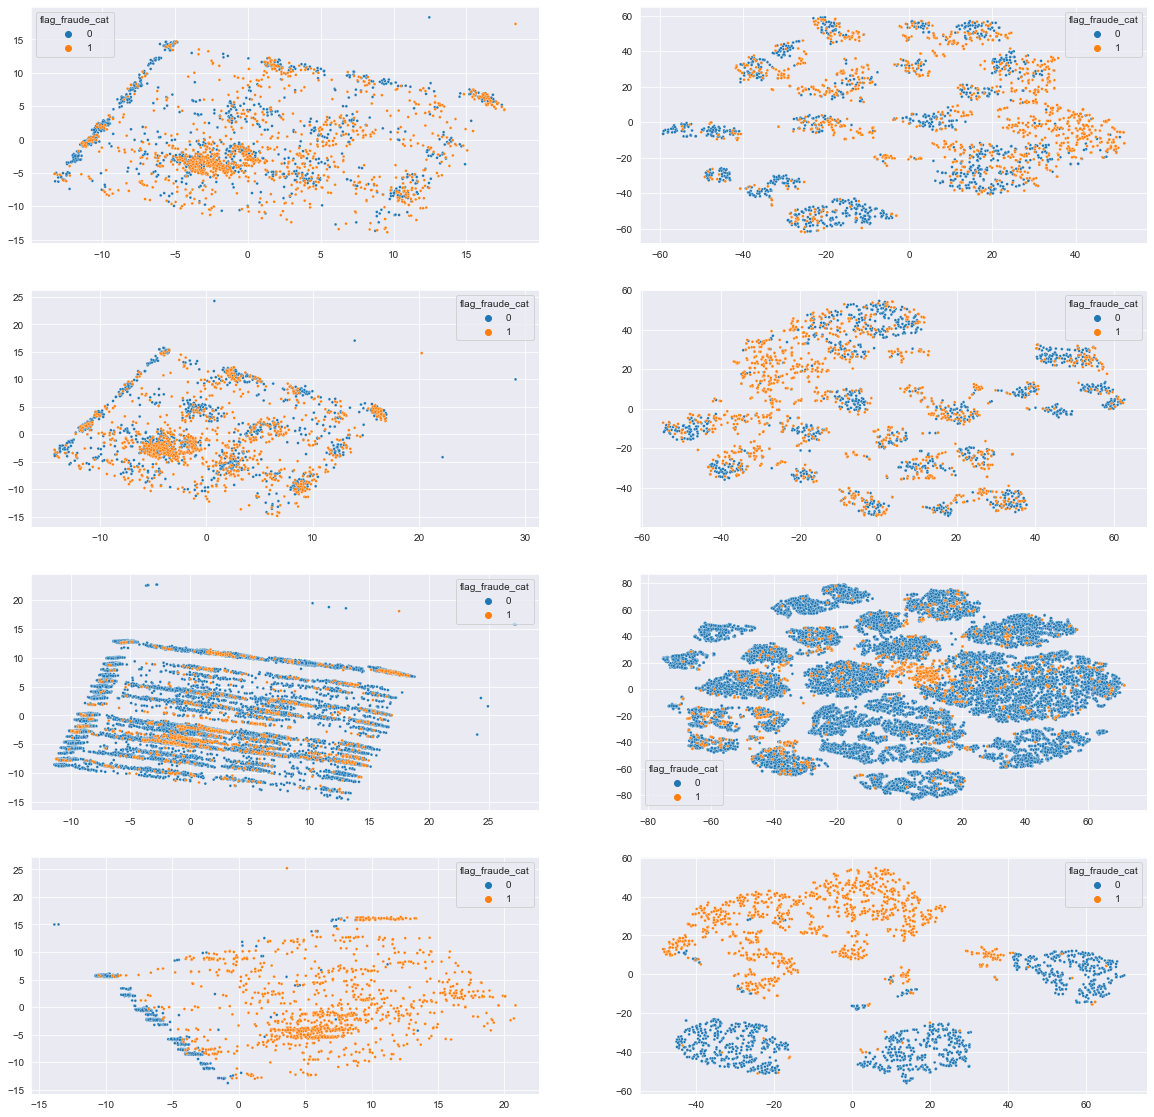

In [101]:
pcas = [pca_rus, pca_cc, pca_enn, pca_iht]
tsnes = [tsne_rus, tsne_cc, tsne_enn, tsne_iht]
ys = [y_rus, y_cc, y_enn, y_iht]

plt.figure(figsize=(20,20))
odds = [1,3,5,7]
evens = [2,4,6,8]
for i in range(4):
    plt.subplot(4,2,odds[i])
    sns.scatterplot(pcas[i][:,0], pcas[i][:,1], hue=ys[i], s=8)

    plt.subplot(4,2,evens[i])
    sns.scatterplot(tsnes[i][:,0], tsnes[i][:,1], hue=ys[i], s=8)
    

In [103]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

pca = PCA(n_components=2)
pca_ros = pca.fit_transform(X_ros)

tsne = TSNE(n_components=2)
tsne_ros = tsne.fit_transform(X_ros)

In [123]:
ros = RandomOverSampler()
X_ros_test, y_ros_test = ros.fit_resample(X_test, y_test)

<AxesSubplot:>

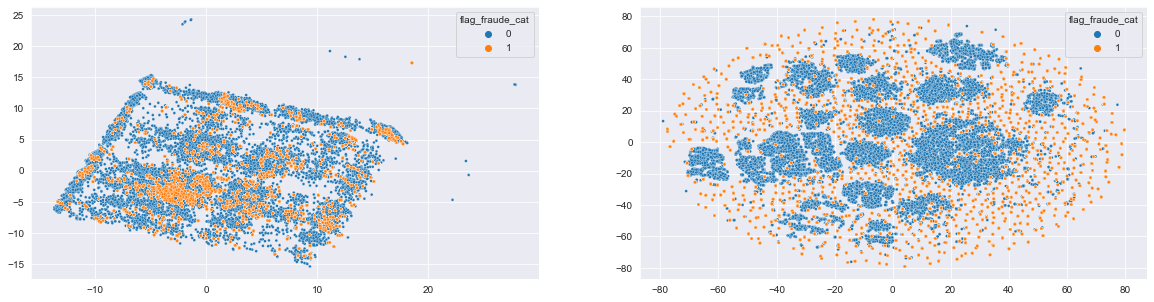

In [106]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.scatterplot(pca_ros[:,0], pca_ros[:,1], hue=y_ros, s=8)

plt.subplot(1,2,2)
sns.scatterplot(tsne_ros[:,0], tsne_ros[:,1], hue=y_ros, s=8)  

## Classification Models

In [114]:
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

metrics:
weighted balanced accuracy
FBeta score
roc auc

In [245]:
from sklearn.metrics import recall_score


lr = LogisticRegression().fit(X_enn.values, y_enn.values)
# y_pred_enn = lr.predict(X_enn_test)
# roc_auc_score(y_enn_test, y_pred_enn), f1_score(y_enn_test, y_pred_enn)
y_pred_enn = lr.predict(X_test.values)
roc_auc_score(y_test.values, y_pred_enn), f1_score(y_test.values, y_pred_enn), recall_score(y_test.values, y_pred_enn)

(0.6416797455537567, 0.3411336453458138, 0.3025830258302583)

In [246]:
lr = LogisticRegression().fit(X_iht, y_iht)
y_pred_iht = lr.predict(X_test)
roc_auc_score(y_test, y_pred_iht), f1_score(y_test, y_pred_iht), recall_score(y_test, y_pred_iht)

(0.5615755299829727, 0.08522204900667546, 0.9833948339483395)

In [248]:
lr = LogisticRegression().fit(X_ros, y_ros)
y_pred_ros = lr.predict(X_test)
roc_auc_score(y_test, y_pred_ros), f1_score(y_test, y_pred_ros), recall_score(y_test, y_pred_ros)

(0.787001289055852, 0.27741935483870966, 0.7140221402214022)

In [249]:
rfc = RandomForestClassifier().fit(X_enn, y_enn)
y_pred_enn = rfc.predict(X_test)
roc_auc_score(y_test, y_pred_enn), f1_score(y_test, y_pred_enn), recall_score(y_test, y_pred_enn)

(0.9932562986189638, 0.8660535785685726, 0.9990774907749077)

In [250]:
rfc = RandomForestClassifier().fit(X_iht, y_iht)
y_pred_iht = rfc.predict(X_test)
roc_auc_score(y_test, y_pred_iht), f1_score(y_test, y_pred_iht), recall_score(y_test, y_pred_iht)

(0.6069896922729667, 0.09400745815627438, 1.0)

In [251]:
rfc = RandomForestClassifier().fit(X_ros, y_ros)
y_pred_ros = rfc.predict(X_test)
roc_auc_score(y_test, y_pred_ros), f1_score(y_test, y_pred_ros), recall_score(y_test, y_pred_ros)

(0.9999059513956813, 0.9976990335941095, 1.0)

In [129]:
svc_model = SVC(class_weight='balanced', probability=True)
svc_model.fit(X, y)
svc_predict = svc_model.predict(X_test)
roc_auc_score(y_test, svc_predict), f1_score(y_test, svc_predict)

(0.8426429767833905, 0.315603463509454)

In [240]:
clf = XGBOD(random_state=42)
clf.fit(X, y)

[08:16:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



XGBOD(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1,
   estimator_list=[KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=1, p=2,
  radius=1.0), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=1, no...x_features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=42,
    verbose=0)],
   gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
   min_child_weight=1, n_estimators=100, n_jobs=1, nthread=None,
   objective='binary:logistic', random_state=42, reg_alpha=0, reg_lambda=1,
   scale_pos_weight=1, silent=True,
   standardization_flag_list=[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, 

In [241]:
y_test_pred = clf.predict(X_test)
clf.decision_function(X_test)

array([0.11357097, 0.13665192, 0.14375123, ..., 0.11174181, 0.12336612,
       0.16933052], dtype=float32)

In [252]:
roc_auc_score(y_test, y_test_pred), f1_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.6336355012034056, 0.37602523659306, 0.27490774907749077)

## Anomaly Detection Models

In [158]:
x_all = X.append(X_test)
y_all = y.append(y_test)

In [150]:
# x_all = x_all.drop_duplicates()

In [159]:
x_normalized = MinMaxScaler().fit_transform(x_all)

In [160]:
lof_pred = LocalOutlierFactor().fit_predict(x_normalized)
lof_pred[lof_pred==-1] = 1

In [253]:
roc_auc_score(y_all, lof_pred), f1_score(y_all, lof_pred), recall_score(y_all, lof_pred)

(0.49657858685656364, 0.07517858381302447, 0.9832199546485261)

In [167]:
isf_pred = IsolationForest().fit_predict(x_normalized)
isf_pred[isf_pred==-1] = 1

In [170]:
roc_auc_score(y_all, isf_pred), f1_score(y_all, isf_pred)

(0.5, 0.07571075401730532)

In [173]:
svm_pred = OneClassSVM().fit_predict(x_normalized)
svm_pred[svm_pred==-1] = 1

In [174]:
roc_auc_score(y_all, svm_pred), f1_score(y_all, svm_pred)

(0.5, 0.07571075401730532)

## Dimensionality Reduction

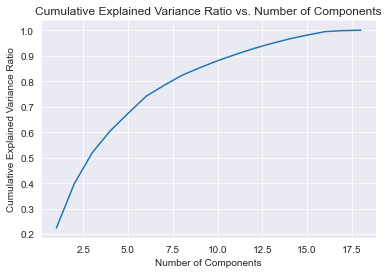

In [177]:
pca = PCA()
pca.fit(x_normalized)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [180]:
x_pca = PCA(10).fit_transform(X_enn)
x_test_pca = PCA(10).fit_transform(X_test)

In [181]:
rfc = RandomForestClassifier().fit(x_pca, y_enn)
y_pred_pca_enn = rfc.predict(x_test_pca)
roc_auc_score(y_test, y_pred_pca_enn), f1_score(y_test, y_pred_pca_enn)

(0.6318387564095338, 0.3589123867069487)

In [184]:
isf_pca_pred = IsolationForest().fit_predict(x_pca)
isf_pca_pred[isf_pca_pred==-1] = 1
roc_auc_score(y_enn, isf_pca_pred), f1_score(y_enn, isf_pca_pred)

(0.5, 0.08065908763850914)

## Time Series

In [195]:
x_window = X.rolling(5).median()
y_window = y.rolling(5).median()


In [193]:
x_window

,mcc_cat,mcc_ant_cat,cep_cat,cep_ant_cat,valor_trans_cat,valor_trans_ant_cat,pos_entry,lim_cred_cat,bandeira_cat,variante_cat,score_cat,tp_pessoa_cat,trans_nacional_cat,qtde_parc_cat,velocidade_cat,dif_score_cat,trans_limit_cat,valor_diff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.0,22.0,3.0,3.0,6.0,6.0,2.0,6.0,2.0,3.0,0.0,1.0,0.0,1.0,4.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9404,6.0,12.0,6.0,1.0,4.0,3.0,2.0,4.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0,3.0
11343,15.0,12.0,6.0,1.0,6.0,5.0,2.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0,3.0
18682,6.0,12.0,2.0,2.0,6.0,5.0,2.0,6.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,3.0,0.0,3.0
18745,6.0,7.0,6.0,4.0,6.0,5.0,2.0,6.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,3.0,0.0,3.0


In [202]:
window = tf.keras.layers.Input(x_window.shape)

layer_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True))(window)
layer_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10))(layer_1)
layer_3 = tf.keras.layers.Dense(200, activation="sigmoid")(layer_2)
layer_4 = tf.keras.layers.Dense(200, activation="sigmoid")(layer_3)
pred = tf.keras.layers.Dense(1, activation="sigmoid")(layer_4)

# Model
model = tf.keras.Model(inputs=[window], outputs=[pred])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss = tf.keras.losses.binary_crossentropy, 
                metrics=['accuracy'])

In [ ]:
history = model.fit(
    x_window.values, y_window.values,
    batch_size=64,
    epochs=5,
    verbose="auto",
    callbacks=None,
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    )

precision_score: 0.8013553182670113
recall_score: 0.7057367226970113
f1_score: 0.7436255552600319
accuracy_score: 0.9690804883242246

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    108522
           1       0.62      0.42      0.50      4190

    accuracy                           0.97    112712
   macro avg       0.80      0.71      0.74    112712
weighted avg       0.96      0.97      0.97    112712




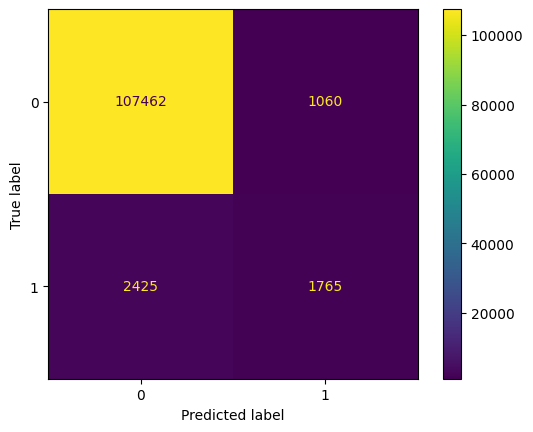

AUC score is  0.9317215509990407


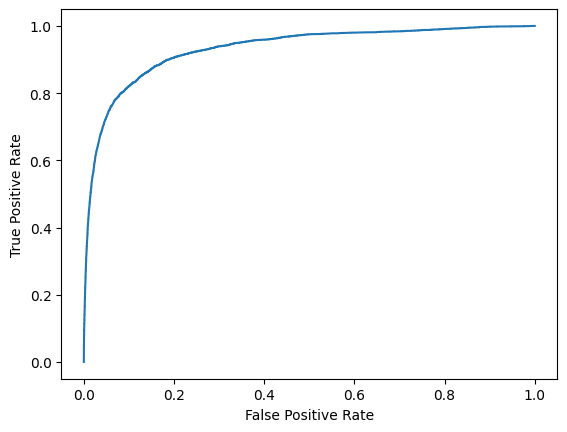

AUPRC score is  0.524369243949152


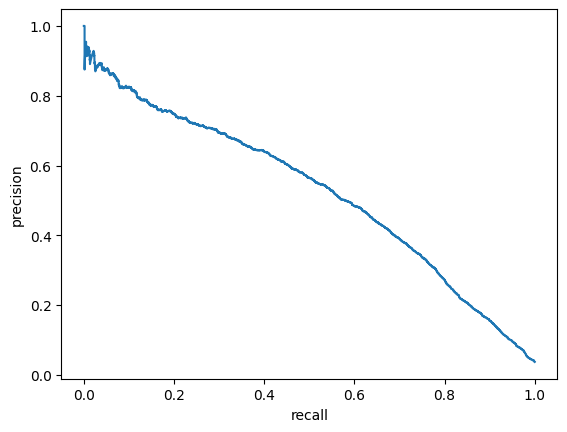

[0.8013553182670113,
 0.7057367226970113,
 0.7436255552600319,
 0.9690804883242246,
 0.9317215509990407,
 0.524369243949152]

In [ ]:
calculate_metrics(y_test_time_seri, y_pred, is_prob=True)

In [236]:
ts = X['valor_diff'].reset_index().drop_duplicates('index')
ts = ts.set_index('index')

In [237]:
ts = ts.sort_index()
ts

,valor_diff
index,
0,0.0
1,0.0
2,0.0
3,3.0
4,0.0
...,...
29089,6.0
29092,0.0
29094,0.0


<AxesSubplot:xlabel='index'>

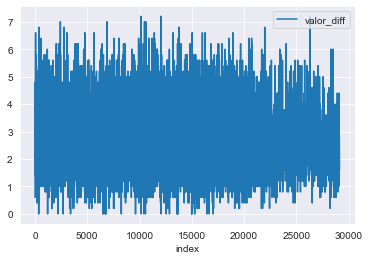

In [238]:
ts.rolling(5).mean().sort_index().plot()

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2.85               58047.0
Prediction (s.d.)         2.86 (1.63)        58359.61 (33255.41)
95% CI                    [-0.45, 5.94]      [-9215.67, 121143.14]

Absolute effect (s.d.)    -0.02 (1.63)       -312.61 (33255.41)
95% CI                    [-3.09, 3.3]       [-63096.14, 67262.67]

Relative effect (s.d.)    -0.54% (56.98%)    -0.54% (56.98%)
95% CI                    [-108.12%, 115.26%][-108.12%, 115.26%]

Posterior tail-area probability p: 0.45
Posterior prob. of a causal effect: 54.75%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2.85. In the absence of an
intervention, we would have expected an average response of 2.86.
The 95% interval of this counterfactual prediction is [-0.45, 5.94].
Subtracting this prediction

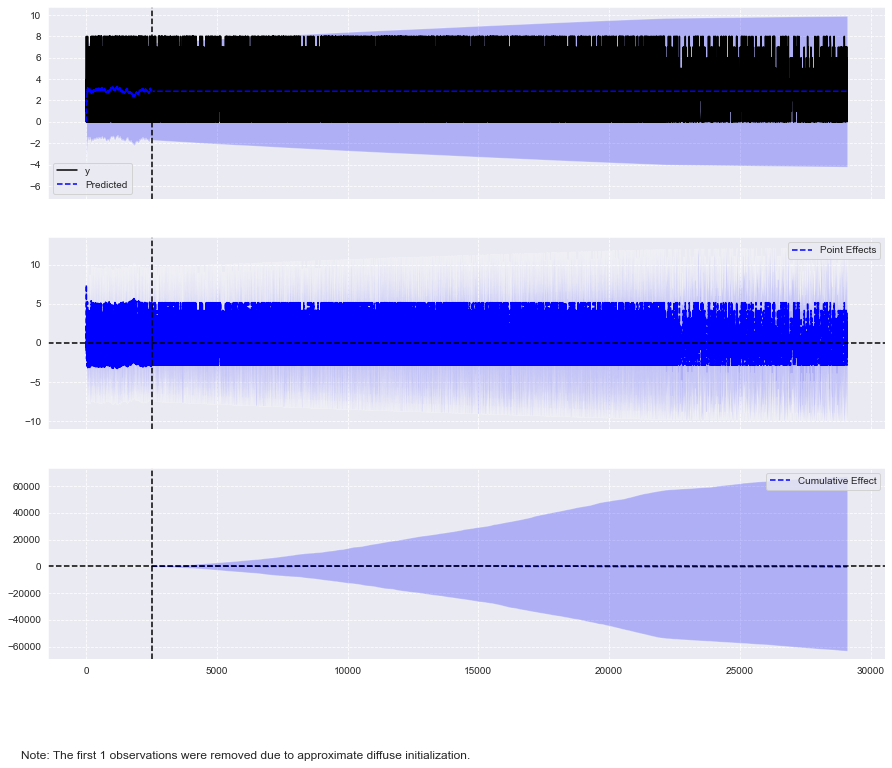

In [239]:
ci = CausalImpact(ts, [0, 2510], [2512,29103],  model_args={'seasonal_period': 52})
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()